<a href="https://colab.research.google.com/github/nour614/Stroke-Prediction-/blob/main/Nour_Tafa_Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Stroke Prediton**##

**Content**

Stroke is the second leading cause of death worldwide, accounting for around 11% of all deaths, according to the World Health Organization. The data set predicts the likelihood of a patient having a stroke based on input parameters such as gender, age, various diseases, and smoking status, with each row containing relevant patient information.

Each row represents a pacient 5110

Classification Problem

This data set has 11 columns and the Target is Stroke




**Culumn** | **Description**  
--- | ---
id|unique identifier
age |age of the patient
gender| "Male", "Female" or "Other"
hypertension| 0 hypertension, 1  hypertension
heart_disease |0  doesn't have diseases, 1  has a heart disease
ever_married| "No" or "Yes"
work_type |"children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
Residence_type|"Rural" or "Urban"
avg_glucose_level| average glucose level in blood
bmi| body mass index
smoking_status| "formerly smoked", "never smoked", "smokes" or "Unknown"
stroke| 1if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient



In [ ]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatplotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer

## Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Classification Metrics
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, RocCurveDisplay, 
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report)

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [ ]:
## Evaluation function
def evluate_classification(model,X_train,X_test,y_train,y_test):
    """Uses model.score to display the accuracy scores for training and test splits"""
    print(f"Training Accuracy: {model.score(X_train, y_train):.3f}")
    print(f"Test Accuracy: {model.score(X_test, y_test):.3f}")

## **1. Load and inspect the data**

In [ ]:
df = pd.read_csv('/content/sample_data/healthcare-dataset-stroke-data.csv')

In [ ]:
backup_df = df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.shape

(5110, 12)

##**2.  Cleaning The Data**##

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
cat_cols = make_column_selector(dtype_include='object')(df)
for col in cat_cols:
  display(df[col].value_counts(normalize=True))

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64

Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64

Urban    0.508023
Rural    0.491977
Name: Residence_type, dtype: float64

never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64

In [ ]:
df.describe(include="number") 

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
df.describe(include="object") 

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


##**Visualization**

**1. BoxPlot**

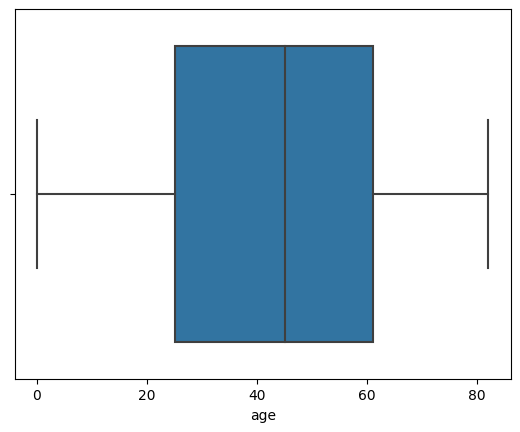

In [ ]:
ax = sns.boxplot(x = 'age', data = df)

There are no age outliers 

**2.  Histogram**

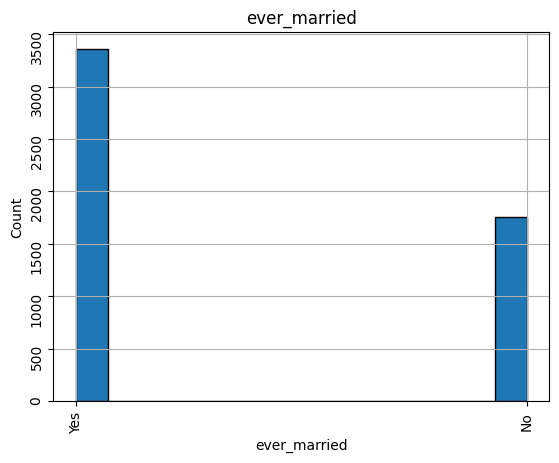

In [ ]:
ax = df['ever_married'].hist(bins='auto', edgecolor='black')
ax.set_xlabel('ever_married')
ax.set_ylabel('Count')

ax.set_title('ever_married')

ax.tick_params(rotation = 90)

Based on the histogram, it appears that there is a higher frequency of individuals who are married compared to those who are not.

**3.  Scatter Plot**

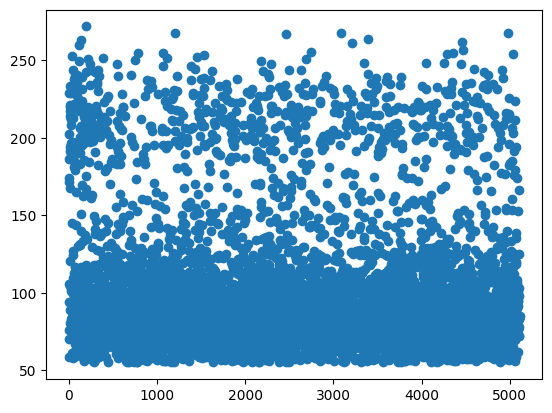

In [ ]:
plt.scatter(df.index,df['avg_glucose_level'])
plt.show()


Based on the scatter plot, it appears that there is a higher density of data points for lower glucose levels. 

**4. BMI Historgam**

(array([ 411., 1964., 1809.,  575.,  105.,   37.,    4.,    2.,    0.,
           2.]),
 array([10.3 , 19.03, 27.76, 36.49, 45.22, 53.95, 62.68, 71.41, 80.14,
        88.87, 97.6 ]),
 <BarContainer object of 10 artists>)

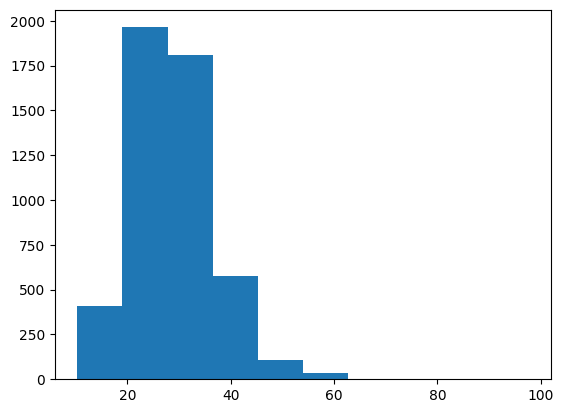

In [ ]:
plt.hist(df['bmi'])

##3. Splitting the data##


In [ ]:
target = 'stroke'
labels=['0', '1']

X = df.drop(columns = ['stroke','id','work_type']).copy()
y = df['stroke'].copy()